In [1]:
#basics
import pandas as pd
import numpy as np
from numpy import mean
# Graphs libraries
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
plt.style.use('seaborn-white')
import seaborn as sns
from IPython.display import Markdown, display
#import plotly.offline as py
#py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.figure_factory as ff
from plotly import tools

from collections import Counter
from tqdm import tqdm
#Fairlearn and imblearn 
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
#scklearn 
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import TruncatedSVD
#AIF360
from aif360.datasets import StandardDataset
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric
from aif360.sklearn.metrics import equal_opportunity_difference
from aif360.algorithms.preprocessing import Reweighing
from aif360.algorithms.preprocessing.lfr import LFR
from aif360.algorithms.preprocessing import DisparateImpactRemover

In [2]:
# define dataset
data = pd.read_csv('dataset_ready2.csv') 
data = data.set_index('ORG_org_uuid')

#More cleaning
data = data.drop(['Unnamed: 0'], axis = 1)
data_orig = data.copy()
#data = data.drop(data[data.unknown_founders != 0].index)
data = data.query('unknown_founders == 0 and female_founders != 0 or male_founders != 0')

data = data.drop(data[data.total_num_founders > 10].index)
data = data.drop(data[data.status == 'operating'].index)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18467 entries, 00072c6c-1d18-61b3-46b2-c647efcc3dd5 to fffc7242-0efe-001a-60c1-49d76b282946
Data columns (total 29 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   company_name              18467 non-null  object 
 1   category_list             18467 non-null  object 
 2   category_group_list       18467 non-null  object 
 3   region                    18467 non-null  object 
 4   city                      18467 non-null  object 
 5   founded_on                18467 non-null  object 
 6   status                    18467 non-null  object 
 7   homepage_url              18467 non-null  object 
 8   city_success_ranking      18467 non-null  float64
 9   region_rank               18467 non-null  float64
 10  multiple_degrees_sum      18467 non-null  float64
 11  multiple_degrees_average  18467 non-null  float64
 12  is_completed_sum          18467 non-null  float64
 13  

In [3]:
counter_before = Counter(data.mostly_male_founders)
print(counter_before)

Counter({1: 16519, 0: 1948})


In [4]:
#data.info()
mostly_female = data[data["mostly_male_founders"] == 0]
avg_no_fem = mostly_female["total_num_founders"].mean()

mostly_male = data[data["mostly_male_founders"] == 1]
avg_no_mal = mostly_male["total_num_founders"].mean()

print(avg_no_fem, avg_no_mal)

2.432751540041068 2.898601610266965


In [5]:
cols_to_drop = ['company_name', 'category_list', 'category_group_list',
               'region', 'city', 'homepage_url', 'founded_on', 'male_founders', 'female_founders'
               ,'unknown_founders']
data.drop(columns = cols_to_drop, inplace = True)
#data_bef_scale = data.copy()

In [6]:
## CREATE A BINARY OUTCOME VARIABLE
#y_variable_bin = y_variable.replace('operating', 1, regex = True)
data.replace('ipo', 1, regex = True, inplace = True)
data.replace('acquired', 1, regex = True, inplace = True)
data.replace('closed', 0, regex = True, inplace = True)

In [7]:
Counter(data.status)

Counter({0: 5038, 1: 13429})

In [8]:
undersample = RandomUnderSampler(sampling_strategy='majority', random_state = 42)
data, data.mostly_male_founders = undersample.fit_resample(data, data.mostly_male_founders)

counter_after = Counter(data.mostly_male_founders)
print(counter_after)


Counter({0: 1948, 1: 1948})


### Transform to AIF360 compatible data 

In [9]:
privileged_groups = [{'mostly_male_founders': 1}]
unprivileged_groups = [{'mostly_male_founders': 0}]


dataset_orig = StandardDataset(data, 
                          label_name='status', 
                          favorable_classes=[1], 
                          protected_attribute_names=['mostly_male_founders'], 
                          privileged_classes=[[1]])

### Split into train, validation and test

In [10]:
dataset_orig_train, dataset_orig_vt = dataset_orig.split([0.75], shuffle=True, seed = 10)
dataset_orig_valid, dataset_orig_test = dataset_orig_vt.split([0.2], shuffle=True, seed = 10)



### Metric for the original training data

In [11]:
metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
display(Markdown("#### Original training dataset"))
print("Difference in mean outcomes = %f" % metric_orig_train.mean_difference())
print("Disparate Impact = %f" %metric_orig_train.disparate_impact())

metric_orig_test = BinaryLabelDatasetMetric(dataset_orig_test, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
display(Markdown("#### Original test dataset"))
print("Difference in mean outcomes = %f" % metric_orig_test.mean_difference())
print("Disparate Impact = %f" %metric_orig_test.disparate_impact())

#### Original training dataset

Difference in mean outcomes = -0.051577
Disparate Impact = 0.927573


#### Original test dataset

Difference in mean outcomes = -0.074342
Disparate Impact = 0.899197


### Train with and transform the original training data - Reweighing 
"Reweighing won't change the training data at all, rather it will learn new weights for each training row that will make the mean difference in outcomes between the specified groups 0."
https://www.kaggle.com/garethjns/titanicsexism-fairness-in-ml

In [12]:
RW = Reweighing(unprivileged_groups=unprivileged_groups,
               privileged_groups=privileged_groups)
RW.fit(dataset_orig_train)
dataset_transf_train = RW.transform(dataset_orig_train)

In [13]:
### Testing 
assert np.abs(dataset_transf_train.instance_weights.sum()-dataset_orig_train.instance_weights.sum())<1e-6

### Metric with the transformed training data 

In [14]:
metric_transf_train = BinaryLabelDatasetMetric(dataset_transf_train, 
                                         unprivileged_groups=unprivileged_groups,
                                         privileged_groups=privileged_groups)
display(Markdown("#### Transformed training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_transf_train.mean_difference())
assert np.abs(metric_transf_train.mean_difference()) < 1e-6


#### Transformed training dataset

Difference in mean outcomes between unprivileged and privileged groups = -0.000000


In [15]:
### Testing 
assert np.abs(metric_transf_train.mean_difference()) < 1e-6

## Train classifier on original data 

In [16]:
# Logistic regression classifier and predictions
scale_orig = MinMaxScaler()
X_train = scale_orig.fit_transform(dataset_orig_train.features)
y_train = dataset_orig_train.labels.ravel()
w_train = dataset_orig_train.instance_weights.ravel()

lmod = LogisticRegression(solver='liblinear')
lmod.fit(X_train, y_train, 
         sample_weight=dataset_orig_train.instance_weights)
y_train_pred = lmod.predict(X_train)

# positive class index
pos_ind = np.where(lmod.classes_ == dataset_orig_train.favorable_label)[0][0]

dataset_orig_train_pred = dataset_orig_train.copy()
dataset_orig_train_pred.labels = y_train_pred

### Scores for original validation and test sets 

In [17]:
dataset_orig_valid_pred = dataset_orig_valid.copy(deepcopy=True)
X_valid = scale_orig.transform(dataset_orig_valid_pred.features)
y_valid = dataset_orig_valid_pred.labels
dataset_orig_valid_pred.scores = lmod.predict_proba(X_valid)[:,pos_ind].reshape(-1,1)

dataset_orig_test_pred = dataset_orig_test.copy(deepcopy=True)
X_test = scale_orig.transform(dataset_orig_test_pred.features)
y_test = dataset_orig_test_pred.labels
dataset_orig_test_pred.scores = lmod.predict_proba(X_test)[:,pos_ind].reshape(-1,1)

### Find the optimal classification threshold from the validation set 

In [18]:
num_thresh = 100
ba_arr = np.zeros(num_thresh)
class_thresh_arr = np.linspace(0.01, 0.99, num_thresh)
for idx, class_thresh in enumerate(class_thresh_arr):
    
    fav_inds = dataset_orig_valid_pred.scores > class_thresh
    dataset_orig_valid_pred.labels[fav_inds] = dataset_orig_valid_pred.favorable_label
    dataset_orig_valid_pred.labels[~fav_inds] = dataset_orig_valid_pred.unfavorable_label
    
    classified_metric_orig_valid = ClassificationMetric(dataset_orig_valid,
                                             dataset_orig_valid_pred, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
    
    ba_arr[idx] = 0.5*(classified_metric_orig_valid.true_positive_rate()\
                       +classified_metric_orig_valid.true_negative_rate())

best_ind = np.where(ba_arr == np.max(ba_arr))[0][0]
best_class_thresh = class_thresh_arr[best_ind]

print("Best balanced accuracy (no reweighing) = %.4f" % np.max(ba_arr))
print("Optimal classification threshold (no reweighing) = %.4f" % best_class_thresh)

Best balanced accuracy (no reweighing) = 0.7295
Optimal classification threshold (no reweighing) = 0.7425


In [19]:
from collections import OrderedDict
from aif360.metrics import ClassificationMetric
def compute_metrics(dataset_true, dataset_pred, 
                    unprivileged_groups, privileged_groups,
                    disp = True):
    """ Compute the key metrics """
    classified_metric_pred = ClassificationMetric(dataset_true,
                                                 dataset_pred, 
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
    metrics = OrderedDict()
    metrics["Accuracy"] = classified_metric_pred.accuracy()
    metrics["Balanced accuracy"] = 0.5*(classified_metric_pred.true_positive_rate()+
                                             classified_metric_pred.true_negative_rate())
    metrics["Average odds difference"] = classified_metric_pred.average_odds_difference()
    metrics["Average absolute odds difference"] = classified_metric_pred.average_abs_odds_difference()
    metrics["Disparate impact"] = classified_metric_pred.disparate_impact()
    metrics["Statistical parity difference (mean difference)"] = classified_metric_pred.statistical_parity_difference()
    metrics["Equal opportunity difference"] = classified_metric_pred.equal_opportunity_difference()
    metrics["Theil index"] = classified_metric_pred.theil_index()
    metrics["Consistency"] = classified_metric_pred.consistency()
    ##ADD MORE METRICS FROM CLASSIFICATIONMETRIC HERE
    if disp:
        for k in metrics:
            print("%s = %.4f" % (k, metrics[k]))
    
    return metrics

## Predictions from the original test set at the optimal classification threshold


In [20]:
display(Markdown("#### Predictions from original testing data"))
bal_acc_arr_orig = []
disp_imp_arr_orig = []
avg_odds_diff_arr_orig = []

print("Classification threshold used = %.4f" % best_class_thresh)
for thresh in tqdm(class_thresh_arr):
    
    if thresh == best_class_thresh:
        disp = True
    else:
        disp = False
    
    fav_inds = dataset_orig_test_pred.scores > thresh
    dataset_orig_test_pred.labels[fav_inds] = dataset_orig_test_pred.favorable_label
    dataset_orig_test_pred.labels[~fav_inds] = dataset_orig_test_pred.unfavorable_label
    
    metric_test_bef = compute_metrics(dataset_orig_test, dataset_orig_test_pred, 
                                      unprivileged_groups, privileged_groups,
                                      disp = disp)

    bal_acc_arr_orig.append(metric_test_bef["Balanced accuracy"])
    avg_odds_diff_arr_orig.append(metric_test_bef["Average odds difference"])
    disp_imp_arr_orig.append(metric_test_bef["Disparate impact"])

#### Predictions from original testing data

Classification threshold used = 0.7425


 82%|██████████████████████████████████▍       | 82/100 [00:01<00:00, 50.32it/s]

Accuracy = 0.6859
Balanced accuracy = 0.6886
Average odds difference = -0.0746
Average absolute odds difference = 0.0746
Disparate impact = 0.8319
Statistical parity difference (mean difference) = -0.1042
Equal opportunity difference = -0.0798
Theil index = 0.2870
Consistency = 0.7064


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 51.60it/s]


### Display results for all thresholds - original test data: abs(1-disparate impact)
Shows that best threshold is at 0,712 (See dotted line in graph below)
abs(1-disparate impact) must be small (close to 0) for classifier predictions to be fair.
The threshold states at which probability LogReg should output 0 or 1. 

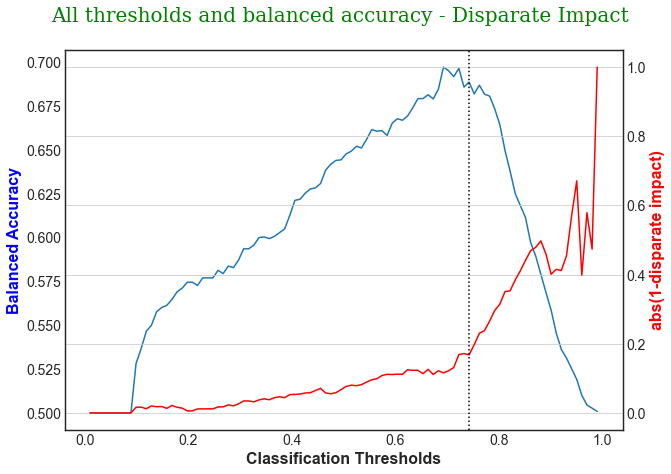

In [21]:
font1 = {'family':'serif','color':'green','size':20}
fig, ax1 = plt.subplots(figsize=(10,7))
plt.title("All thresholds and balanced accuracy - Disparate Impact \n", fontdict = font1)
ax1.plot(class_thresh_arr, bal_acc_arr_orig)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, np.abs(1.0-np.array(disp_imp_arr_orig)), color='r')
ax2.set_ylabel('abs(1-disparate impact)', color='r', fontsize=16, fontweight='bold')
ax2.axvline(best_class_thresh, color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

### Display results for all thresholds - original test data: avg odds difference 



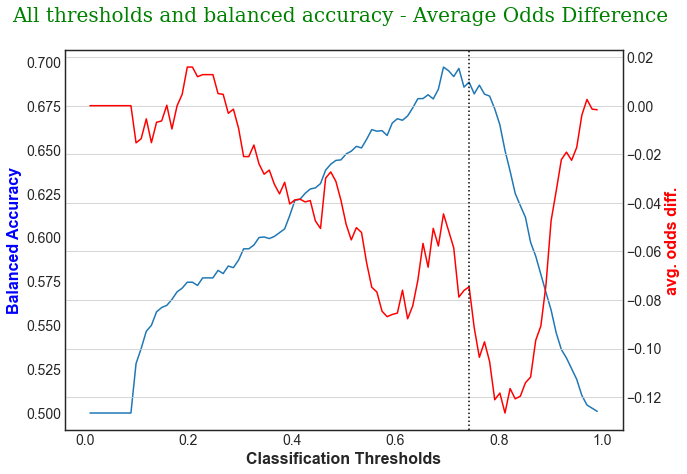

In [22]:
##The classification threshold states at what probability logreg should say 0 or 1.
fig, ax1 = plt.subplots(figsize=(10,7))
plt.title("All thresholds and balanced accuracy - Average Odds Difference \n", fontdict = font1)
ax1.plot(class_thresh_arr, bal_acc_arr_orig)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)

ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, avg_odds_diff_arr_orig, color='r')
ax2.set_ylabel('avg. odds diff.', color='r', fontsize=16, fontweight='bold')
ax2.axvline(best_class_thresh, color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

## Train classifier on transformed data

In [23]:
scale_transf = StandardScaler()
X_train = scale_transf.fit_transform(dataset_transf_train.features)
y_train = dataset_transf_train.labels.ravel()

lmod = LogisticRegression(solver='liblinear')
lmod.fit(X_train, y_train,
        sample_weight=dataset_transf_train.instance_weights)
y_train_pred = lmod.predict(X_train)

### Obtain scores for transformed test set 

In [24]:
dataset_transf_test_pred = dataset_orig_test.copy(deepcopy=True)
X_test = scale_transf.fit_transform(dataset_transf_test_pred.features)


y_test = dataset_transf_test_pred.labels
dataset_transf_test_pred.scores = lmod.predict_proba(X_test)[:,pos_ind].reshape(-1,1)

In [25]:
#print(classification_report(dataset_orig_test.labels, dataset_transf_test.labels))

## Predictions from the transformed test set at the optimal classification threshold


In [26]:
display(Markdown("#### Predictions from transformed testing data"))
bal_acc_arr_transf = []
disp_imp_arr_transf = []
avg_odds_diff_arr_transf = []

print("Classification threshold used = %.4f" % best_class_thresh)
for thresh in tqdm(class_thresh_arr):
    
    if thresh == best_class_thresh:
        disp = True
    else:
        disp = False
    
    fav_inds = dataset_transf_test_pred.scores > thresh
    dataset_transf_test_pred.labels[fav_inds] = dataset_transf_test_pred.favorable_label
    dataset_transf_test_pred.labels[~fav_inds] = dataset_transf_test_pred.unfavorable_label
    
    metric_test_aft = compute_metrics(dataset_orig_test, dataset_transf_test_pred, 
                                      unprivileged_groups, privileged_groups,
                                      disp = disp)

    bal_acc_arr_transf.append(metric_test_aft["Balanced accuracy"])
    avg_odds_diff_arr_transf.append(metric_test_aft["Average odds difference"])
    disp_imp_arr_transf.append(metric_test_aft["Disparate impact"])

#### Predictions from transformed testing data

Classification threshold used = 0.7425


 83%|██████████████████████████████████▊       | 83/100 [00:01<00:00, 53.86it/s]

Accuracy = 0.6731
Balanced accuracy = 0.6844
Average odds difference = 0.0152
Average absolute odds difference = 0.0401
Disparate impact = 0.9492
Statistical parity difference (mean difference) = -0.0284
Equal opportunity difference = -0.0249
Theil index = 0.3095
Consistency = 0.7064


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 53.39it/s]


### Display results for all thresholds - transformed data: abs(1-disparate impact) 


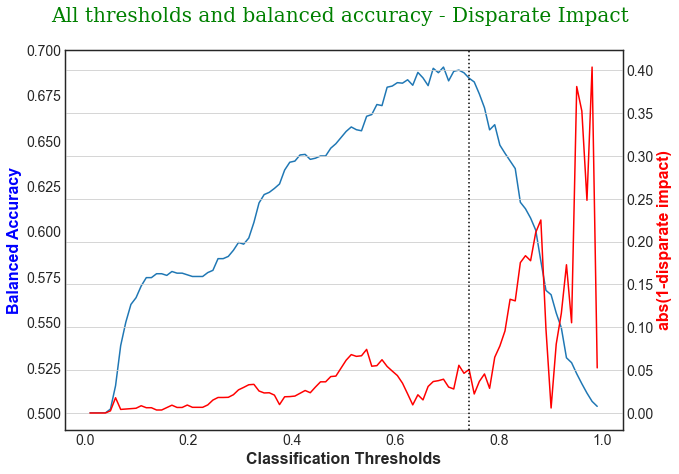

In [27]:
fig, ax1 = plt.subplots(figsize=(10,7))
plt.title("All thresholds and balanced accuracy - Disparate Impact \n", fontdict = font1)
ax1.plot(class_thresh_arr, bal_acc_arr_transf)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)
ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, np.abs(1.0-np.array(disp_imp_arr_transf)), color='r')
ax2.set_ylabel('abs(1-disparate impact)', color='r', fontsize=16, fontweight='bold')
ax2.axvline(best_class_thresh, color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

### Display results for all thresholds - transformed data: average odds difference



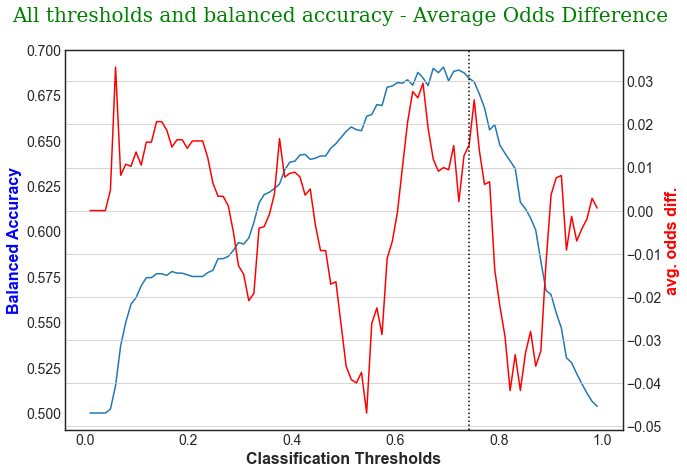

In [28]:
fig, ax1 = plt.subplots(figsize=(10,7))
plt.title("All thresholds and balanced accuracy - Average Odds Difference \n", fontdict = font1)
ax1.plot(class_thresh_arr, bal_acc_arr_transf)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)
ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, avg_odds_diff_arr_transf, color='r')
ax2.set_ylabel('avg. odds diff.', color='r', fontsize=16, fontweight='bold')
ax2.axvline(best_class_thresh, color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)